In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output, Audio
%matplotlib inline
# %matplotlib widget
plt.rcParams['figure.dpi']= 150

In this notebook, we investigate the steady states of the inner medulla model using a dynamical simulation.
Previously, we discovered that the inner medulla model can have at least two steady states which come closer together as we either increase the salt and urea permeability or increase the salt source in the central core.
In the latter scenario, we observe that the two solution seems to merge into one, after which we failed to obtain convergence of a numerical simulation.
However, this kind of behavior is unclear in the earlier case where the solutions fail to converge even before we see the merging --- if this even occur at all.

## Dynamical simulation without salt dump

We anticipate that the two steady state solutions that we found before introducing the salt dump include one unstable and one stable steady states.
Thus, we first experiment numerically and see if this is true.
The equations are detailed in the document.
In short, we assume rigid tubes and central core (4 equations for the water flows remain the same) and the time derivatives only appear in the 5 equations for the solutes.


In [2]:
# Transport parameters
s_perm = 1.2
u_perm_val = 1.2
w_D_perm = 10
w_C_perm = 10
S_input = 0.8
U_input = 2
osm_input = 2
u_frac = 1
s_dump = 0
# s_dump = 0.0285
a_D = 0.25
a_C = 0.25
a_A = 0.25
a_0 = 0.25

# discretization
N = 50
dx = 1/N
dt = 0.5

In [3]:
def diff_x(y): 
    n = len(y)-1
    diff = np.zeros(n)
    for l in range(n):
        diff[l] = (y[l+1]-y[l])/dx
    
    return diff

def avg(y):
    n = len(y)-1
    average = np.zeros(n)
    for l in range(n):
        average[l] = (y[l+1]+y[l])/2
    
    return average

In [4]:
y_init = np.zeros(5*N+3*(N+1)+1)
s_D_init = y_init[:N]
s_A_init = y_init[N:2*N]
s_0_init = y_init[2*N:3*N]
u_C_init = y_init[3*N:4*N]
u_0_init = y_init[4*N:5*N]
q_D_init = y_init[5*N:6*N+1]
q_A_init = y_init[6*N+1:6*N+2]
q_C_init = y_init[6*N+2:7*N+3]
q_0_init = y_init[7*N+3:8*N+4]

unstable = np.load('./unstable.npy')
q_D_init[:] = unstable[2*(N+1):3*(N+1)]
q_A_init[:] = -q_D_init[-1]
q_C_init[:] = unstable[3*(N+1):4*(N+1)]
q_0_init[:] = q_C_init[-1] - q_C_init - q_A_init - q_D_init
s_D_init[:] = S_input/avg(q_D_init)
s_A_init[:] = avg(unstable[:(N+1)])/q_A_init
s_0_init[:] = (unstable[N] - avg(unstable[:(N+1)]))/avg(q_0_init)
u_C_init[:] = avg(unstable[(N+1):2*(N+1)])/avg(q_C_init)
u_0_init[:] = (unstable[2*N+1] - avg(unstable[(N+1):2*(N+1)]))/avg(q_0_init)


In [5]:
def fw_euler(y_0):
    s_D_0 = y_0[:N]
    s_A_0 = y_0[N:2*N]
    s_0_0 = y_0[2*N:3*N]
    u_C_0 = y_0[3*N:4*N]
    u_0_0 = y_0[4*N:5*N]
    q_D_0 = y_0[5*N:6*N+1]
    q_A_0 = y_0[6*N+1:6*N+2]
    q_C_0 = y_0[6*N+2:7*N+3]
    q_0_0 = y_0[7*N+3:8*N+4]

    y = y_0.copy()
    s_D = y[:N]
    s_A = y[N:2*N]
    s_0 = y[2*N:3*N]
    u_C = y[3*N:4*N]
    u_0 = y[4*N:5*N]
    q_D = y[5*N:6*N+1]
    q_A = y[6*N+1:6*N+2]
    q_C = y[6*N+2:7*N+3]
    q_0 = y[7*N+3:8*N+4]

    S_D_0 = s_D_0*avg(q_D_0)
    div_S_D = np.zeros(N)
    div_S_D[0] = 2*(S_D_0[0] - S_input)/dx
    div_S_D[1:] = diff_x(S_D_0)
    s_D[:] = s_D_0 + dt*(-div_S_D)/a_D

    S_A_0 = s_A_0*q_A_0
    div_S_A = np.zeros(N)
    # div_S_A[-1] = 2*(
    #     q_A_0[-1]*(s_D_0[-1]+s_A_0[-1])/2 - S_A_0[-1]
    #     )/dx
    div_S_A[-1] = 2*(
        (q_A_0 - q_D_0[-2])*s_D_0[-1]/2 - S_A_0[-1]
        )/dx
    div_S_A[:-1] = diff_x(S_A_0)
    j_s = s_perm*(s_A_0 - s_0_0)
    s_A[:] = s_A_0 + dt*(
        -div_S_A -j_s
    )/a_A

    S_0_0 = s_0_0*avg(q_0_0)
    div_S_0 = np.zeros(N)
    div_S_0[-1] = 2*( - S_0_0[-1])/dx
    div_S_0[:-1] = diff_x(S_0_0)
    s_0[:] = s_0_0 + dt*(
        -div_S_0 +j_s + s_dump
    )/a_0

    u_perm = np.zeros(N)
    for l in range(N):
        perm_grids = u_frac*N
        insul = np.floor(N-perm_grids)
        if l==insul:
            u_perm[l] = u_perm_val*(perm_grids - np.ceil(perm_grids-1))
        elif l>insul:
            u_perm[l] = u_perm_val

    U_C_0 = u_C_0*avg(q_C_0)
    div_U_C = np.zeros(N)
    div_U_C[0] = 2*(U_C_0[0] - U_input)/dx
    div_U_C[1:] = diff_x(U_C_0)
    j_u = u_perm*(u_C_0 - u_0_0)
    u_C[:] = u_C_0 + dt*(
        -div_U_C - j_u
    )/a_C

    U_0_0 = u_0_0*avg(q_0_0)
    div_U_0 = np.zeros(N)
    div_U_0[-1] = 2*( - U_0_0[-1])/dx
    div_U_0[:-1] = diff_x(U_0_0)
    u_0[:] = u_0_0 + dt*(
        - div_U_0 + j_u
    )/a_0

    q_D[0] = 2*S_input/osm_input
    q_C[0] = U_input/osm_input
    w_C = w_C_perm*(2*s_0+u_0-u_C)
    w_D = w_D_perm*(2*s_0+u_0-2*s_D)
    q_0[-1] = 0
    for k in range(N):
        q_D[k+1] = q_D[k] + dx*(-w_D[k])
        q_C[k+1] = q_C[k] + dx*(-w_C[k])
        q_0[N-k-1] = q_0[N-k]+dx*(-w_C[N-k-1]-w_D[N-k-1])
    q_A[:] = -q_D[-1]
    
    return y

In [6]:
# Transport parameters
s_perm = 1.2
u_perm_val = 1.2
w_D_perm = 10
w_C_perm = 10
S_input = 0.8
U_input = 2
osm_input = 2
u_frac = 1
s_dump = 0
# s_dump = 0.0285
a_D = 0.25
a_C = 0.25
a_A = 0.25
a_0 = 0.25

# discretization
N = 50
dx = 1/N
steps = 16000
# steps = 1000
dt = 0.0025

y = y_init.copy()
# y = y[:-1001]

for n in range(steps):
    y = np.vstack((y,np.zeros(8*N+4)))
    y[-1,:] = fw_euler(y[-2,:])

s_D = y[:,:N]
s_A = y[:,N:2*N]
s_0 = y[:,2*N:3*N]
u_C = y[:,3*N:4*N]
u_0 = y[:,4*N:5*N]
q_D = y[:,5*N:6*N+1]
q_A = y[:,6*N+1:6*N+2]
q_C = y[:,6*N+2:7*N+3]
q_0 = y[:,7*N+3:8*N+4]

osm_D = 2*s_D[-1,:]
osm_A = 2*s_A[-1,:]
osm_C = u_C[-1,:]
osm_0 = 2*s_0[-1,:]+u_0[-1,:]

from winsound import Beep
Beep(300, 200)
Beep(300, 200)
Beep(300, 200)

<function matplotlib.pyplot.show(close=None, block=None)>

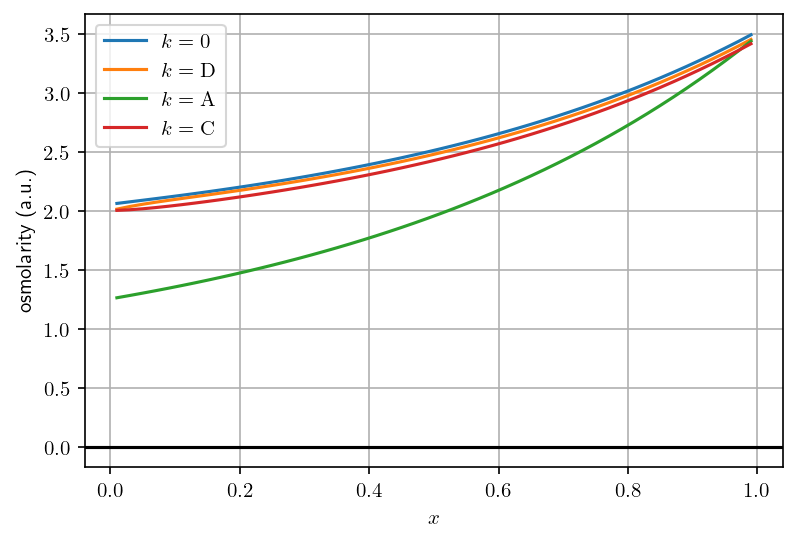

In [16]:
# Plotting osmolarity
osm_D = 2*s_D[-1,:]
osm_A = 2*s_A[-1,:]
osm_C = u_C[-1,:]
osm_0 = 2*s_0[-1,:]+u_0[-1,:]
x = np.linspace(0,1,num=N+1)
x_avg = np.linspace(dx/2,1-dx/2,num=N)
compartments = ['0','\mathrm{D}','\mathrm{A}','\mathrm{C}']
osm = [osm_0,osm_D,osm_A,osm_C]

fig, ax = plt.subplots()
plt.rcParams['text.usetex'] = True
ax.grid(True, which='both')
ax.axhline(y=0, color='k')
for k in range(4):
    ax.plot(x_avg,osm[k],label=r'$k={}$'.format(compartments[k]))
ax.legend()
plt.xlabel(r"$x$")
plt.ylabel(r"osmolarity (a.u.)")
plt.show

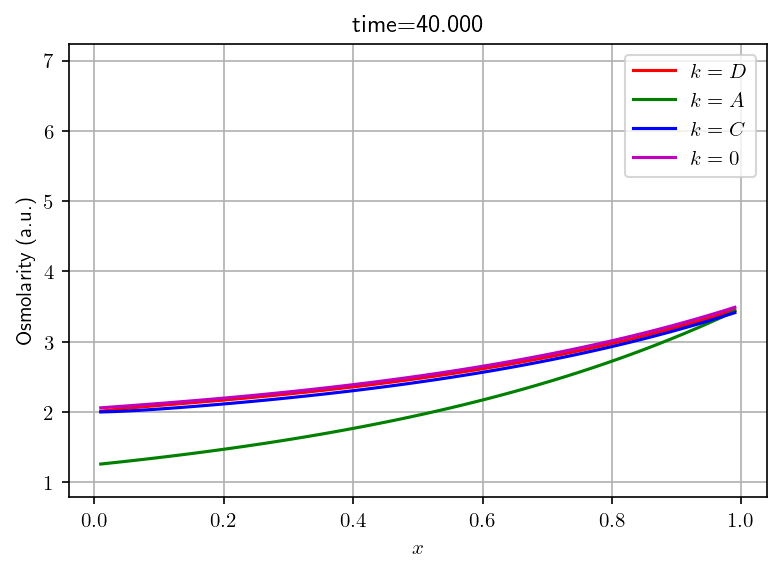

In [13]:
# animation
import matplotlib.animation as animation
fig, ax = plt.subplots()
plt.rcParams['text.usetex'] = True
ax.grid(True, which='both')
x_avg = np.linspace(dx/2,1-dx/2,num=N)


osm_D = 2*s_D[:16001,:]
osm_A = 2*s_A[:16001,:]
osm_C = u_C[:16001,:]
osm_0 = 2*s_0[:16001,:]+u_0[:16001,:]

line1, = ax.plot(x_avg, osm_D[0,:], color = "r", label=r'$k=D$')
line2, = ax.plot(x_avg, osm_A[0,:], color = "g", label=r'$k=A$')
line3, = ax.plot(x_avg, osm_C[0,:], color = "b", label=r'$k=C$')
line4, = ax.plot(x_avg, osm_0[0,:], color = "m", label=r'$k=0$')

def update(num, x, y1, y2, y3, y4, line1, line2, line3, line4):
    line1.set_data(x, y1[100*num,:])
    line2.set_data(x, y2[100*num,:])
    line3.set_data(x, y3[100*num,:])
    line4.set_data(x, y4[100*num,:])
    ax.set_title(f"time={100*num*0.0025:.3f}")
    return [line1,line2,line3,line4]

ax.legend()
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'Osmolarity (a.u.)')

# ani = animation.FuncAnimation(fig, update, frames=1601, fargs=[x_avg, osm_D, osm_A, osm_C, osm_0, line1, line2, line3, line4],
#                   interval=100, blit=True)

# plt.show()
# plt.rcParams["animation.html"] = "jshtml"
ani = animation.FuncAnimation(fig, update, frames=161, fargs=[x_avg, osm_D, osm_A, osm_C, osm_0, line1, line2, line3, line4],
                  interval=20, blit=True)
from IPython.display import HTML
# HTML(ani.to_html5_video())
display(HTML(ani.to_jshtml()))
ani.save('stable1.gif')

In [14]:
np.save('dynamic_stable.npy',y)